<h1><center>Języki programowania w analize danych</center></h1>
<h3><center><ul style="list-style: none;">
    <li>Jakub Kurek 234078</li>
    <li>Mateusz Gałasiński 234054</li>
    </ul></center></h3> 
<h2><center>Zadanie 2 - Przetwarzanie danych brakujących - imputacja danych</center></h2>

## Import section

In [1]:
!pip install missingno > /dev/null
!pip install tabulate > /dev/null

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from tabulate import tabulate
from IPython.display import display
%matplotlib inline

### Read data, treat 0 as NaN

In [3]:
def nan_data(df, percent):
    return df.mask(np.random.random(df.shape) < percent)

missing_values = [0]
data = pd.read_csv("./data/Fish.csv", na_values=missing_values)
original_data = data.copy()
data[data.drop(columns='Species').columns] = nan_data(data.drop(columns='Species'), 0.11)

####  Describe data

In [4]:
print(data.describe())
print("-----------------------------------")
print(data.head(10))

            Weight     Length1     Length2     Length3      Height       Width
count   145.000000  144.000000  141.000000  148.000000  145.000000  144.000000
mean    410.413103   26.140972   28.053191   31.450000    9.024723    4.359790
std     361.686843   10.008223   10.429796   11.814775    4.327326    1.706826
min       5.900000    7.500000    8.400000    8.800000    1.728400    1.047600
25%     130.000000   19.000000   21.000000   23.025000    5.936400    3.344950
50%     300.000000   25.100000   26.500000   30.700000    7.792000    4.219100
75%     650.000000   32.550000   35.000000   39.975000   12.431300    5.582250
max    1650.000000   59.000000   63.400000   68.000000   18.957000    8.142000
-----------------------------------
  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0      NaN     26.5     31.1  12.3778  4.6961
3   B

## Visualize missing data

#### Percentage of missing data + non-missing data as bars

Species     0.000000
Weight      8.805031
Length1     9.433962
Length2    11.320755
Length3     6.918239
Height      8.805031
Width       9.433962
dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


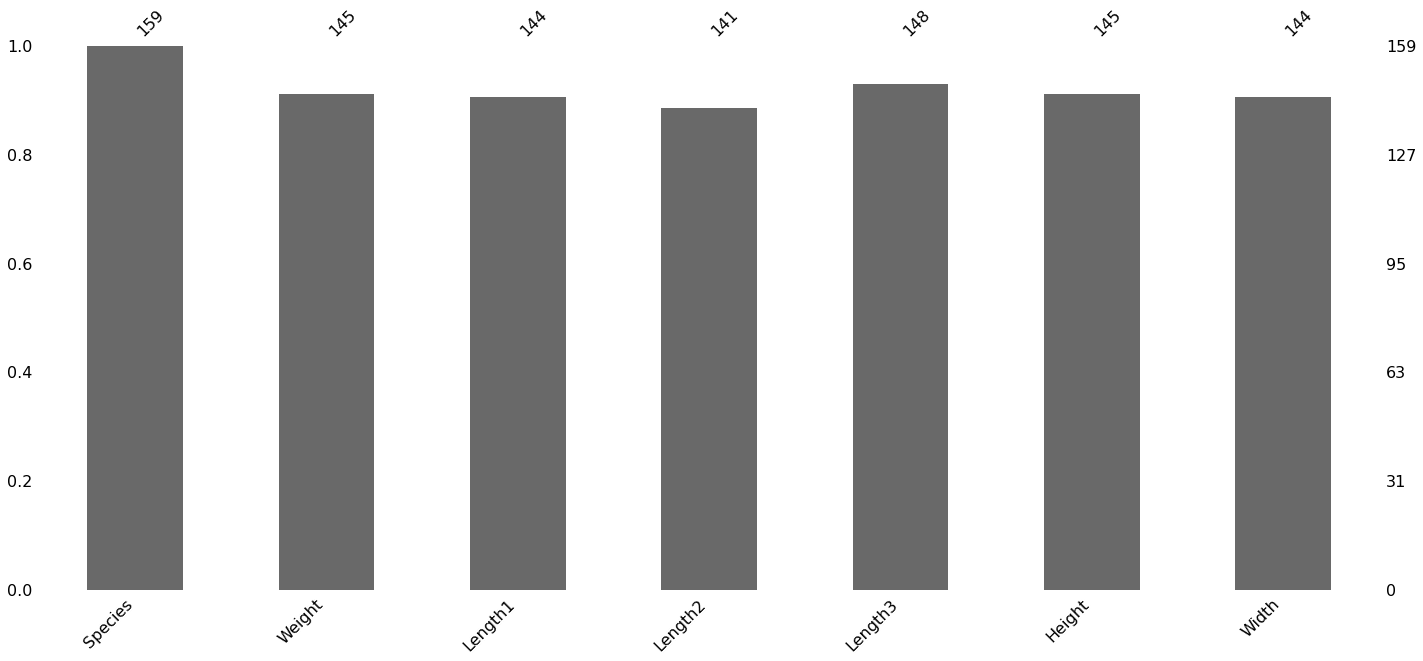

In [5]:
print(data.isnull().sum() * 100 / len(data))
print(msno.bar(data))

#### Missing data matrix and "heatmap"

AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)


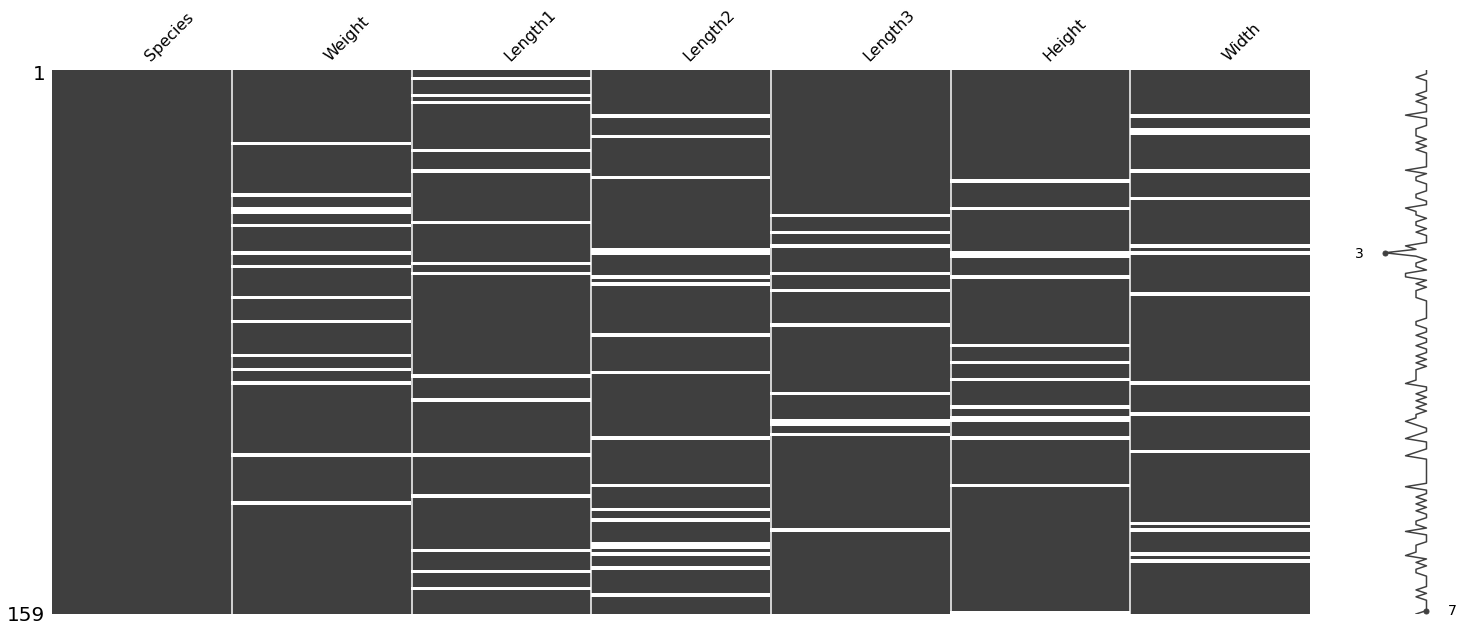

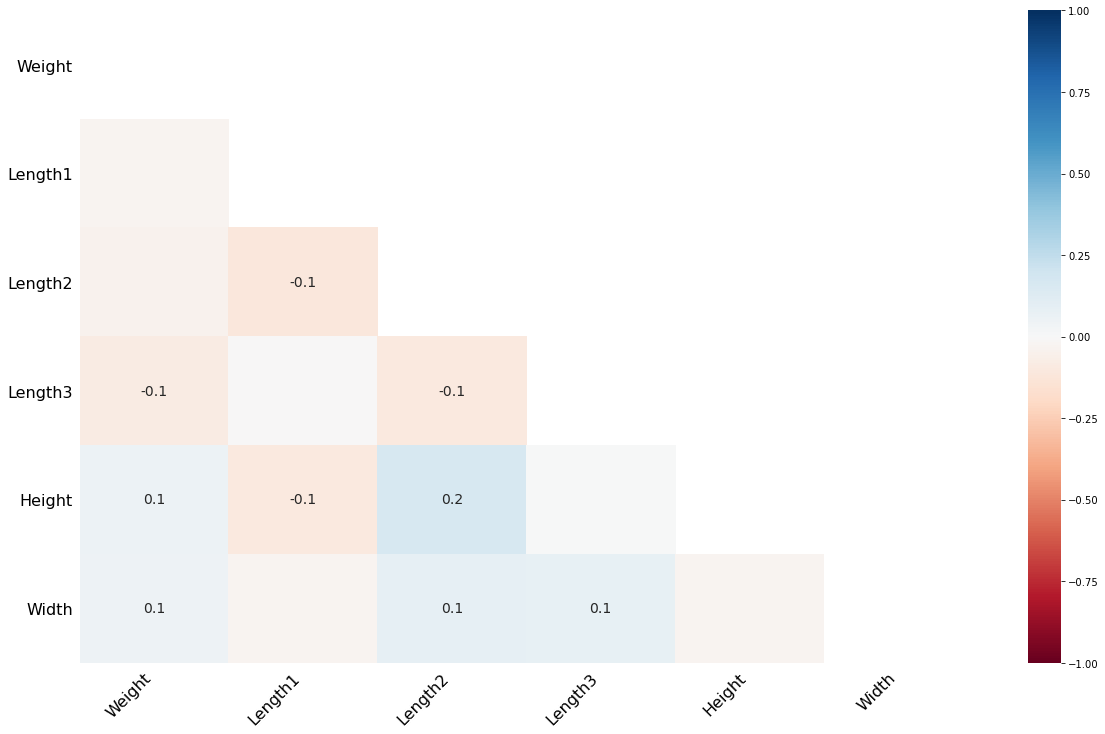

In [6]:
print(msno.matrix(data))
# heatmap show correlation nullity correlation:
# how strongly the presence or absence of one variable affects the presence of another
print(msno.heatmap(data)) 

# Regression

Type,Number of samples,linear regression,bayesian ridge
"Full, original data",158,0.0271,0.027
deleted NaN rows,128,0.0258,0.0257
Mean imputation,159,0.0236,0.0234
Interpolation imputation,159,0.026,0.0259
Hot Deck LOCF imputation,159,0.0242,0.024
LinearRegression imputation,159,0.0276,0.0276
BayesianRidge imputation,159,0.0275,0.0275


Weight


,mean,std,min,25%,50%,75%,max
"Full, original data",400.847,357.698,5.9,121.25,281.5,650,1650
deleted NaN rows,402.862,357.101,5.9,128.75,281.5,627.5,1650
Mean imputation,410.413,345.291,5.9,142.5,340,605,1650
Interpolation imputation,400.436,357.761,5.9,122.5,290,635,1650
Hot Deck LOCF imputation,399.408,359.434,5.9,120,273,635,1650
LinearRegression imputation,400.834,354.369,-62.7119,132.5,290,635,1650
BayesianRidge imputation,400.843,354.353,-62.2841,132.5,290,635,1650


Length2


,mean,std,min,25%,50%,75%,max
"Full, original data",28.4658,10.7317,8.4,21,27.4,35.75,63.4
deleted NaN rows,28.3719,10.5949,8.4,21.225,27.4,35,63.4
Mean imputation,28.0532,9.81773,8.4,21.75,28.0532,34.5,63.4
Interpolation imputation,28.583,10.6461,8.4,21,27.5,36,63.4
Hot Deck LOCF imputation,28.7031,10.9138,8.4,21,27.5,36,63.4
LinearRegression imputation,28.2749,10.4553,8.4,21,26.5,35,63.4
BayesianRidge imputation,28.2747,10.4539,8.4,21,26.5,35,63.4


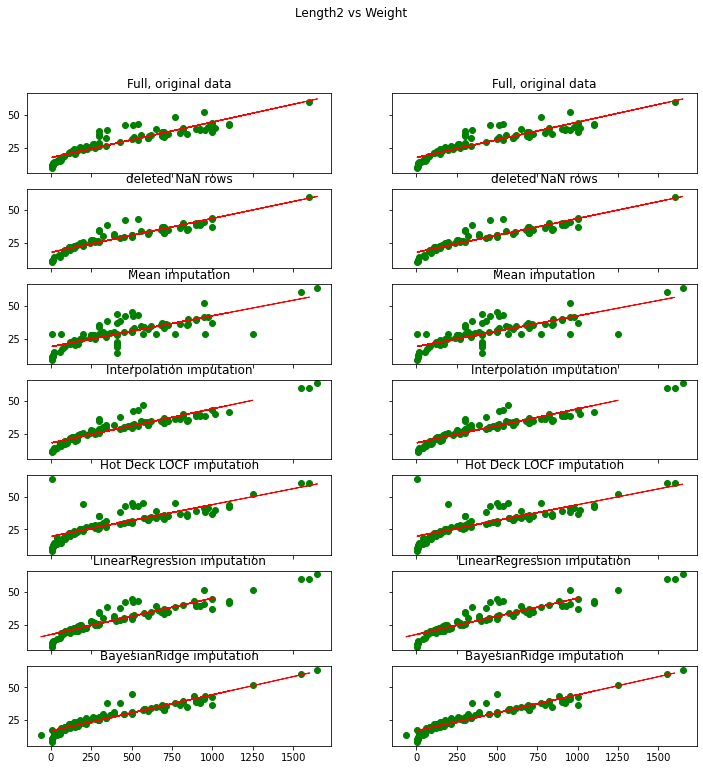

In [7]:
def plot_data(axes, title, x_train, y_train, x_test, y_test):
    axes.set_title(title)
    axes.scatter(x_train, y_train, color="green"),
    axes.plot(x_test, y_test, color="red", linewidth=1)

models = [LinearRegression(),
          BayesianRidge()]

res, stats_x, stats_y = [], [], []
colx, coly = 'Weight', 'Length2'
to_df = lambda a: pd.DataFrame(data=a, index=range(len(a)), columns=[colx, coly])
iter_imputer = lambda m: (lambda a: IterativeImputer(estimator=m, max_iter=20, random_state=0).fit_transform(a), f"{m.__class__.__name__} imputation", data)
cases = [
    (None, "Full, original data", original_data),
    (None, "deleted NaN rows", data),
    (lambda a: SimpleImputer().fit_transform(a), "Mean imputation", data),
    (lambda a: to_df(a).interpolate().to_numpy(), "Interpolation imputation", data),
    (lambda a: to_df(a).fillna(method='ffill').to_numpy(), "Hot Deck LOCF imputation", data),
    iter_imputer(models[0]),
    iter_imputer(models[1])
]
f, axarr = plt.subplots(len(cases), len(models), sharex=True, sharey=True,figsize=(12,12))
f.suptitle(f"{coly} vs {colx}")
for i, (imputer, title, datasource) in enumerate(cases):
    data_slice = datasource[[colx, coly]]
    if imputer == None:
        data_slice = data_slice.dropna()
    data_slice = data_slice.to_numpy()
    if imputer != None:
        data_slice=imputer(data_slice)
    xs = data_slice[:,0].reshape((-1,1))
    ys = data_slice[:,1].reshape((-1,1))
    x_train,x_test,y_train,y_test=train_test_split(xs,ys,test_size=0.4)
    coeffs = []
    for y, model in enumerate(models):
        y_test = model.fit(x_train,y_train.ravel()).predict(x_test)
        plot_data(axarr[i,y], title, x_train, y_train, x_test, y_test)
        coeffs.append(model.coef_.ravel()[0])
    res.append((title, len(xs), f"{coeffs[0]:.4f}", f"{coeffs[1]:.4f}"))
    descr = pd.DataFrame(data=data_slice, columns=[colx, coly]).describe()
    for c, stats in [(colx, stats_x), (coly, stats_y)]:
        stats.append((title, descr[c]["mean"], descr[c]["std"],
                      descr[c]["min"], descr[c]["25%"], descr[c]["50%"],
                      descr[c]["75%"], descr[c]["max"]))

display(tabulate(res, headers=['Type', 'Number of samples', 'linear regression', 'bayesian ridge'], tablefmt="html"))
print("Weight")
display(tabulate(stats_x, headers=['mean', 'std', 'min', '25%', '50%', '75%', 'max'], tablefmt="html"))
print("Length2")
display(tabulate(stats_y, headers=['mean', 'std', 'min', '25%', '50%', '75%', 'max'], tablefmt="html"))